# Analysis of Union College math major student data

## Part 4 - Preliminary hypothesis testing

General notes on interpretation:
* In short, these results are preliminary
<br><br>
* **Effect size** and **confidence interval** provide an estimate of the magnitude and precision of an observed difference between groups
  + **Cohen's d** measures the magnitude of the difference between two means in units of standard deviations.
  + The **probability of superiority** (aka. the common language effect size) gives the probability that a randomly selected member of one group has a greater score than a randomly selected member of another group.
<br><br>
* The **p-value** serves as a guideline for significance; however: 
  + Using a significance cutoff of 0.05 still has 1 in 20 chance of a false positive
  + Any non-statistically significant results are best considered as inconclusive rather than as no effect (especially when the p-value or the power is relatively low)
<br><br>
* Post hoc **power analysis** informs on the number of samples needed to reject a false null hypothesis, however;
  + Here, it is based on the observed effect size, and so if the confidence interval spans a wide range, the power also has potentially large error.
<br><br>
* Since this setting is not experimental we cannot infer causation
  + Alternative plausible explanations for results should be considered

## Set up the notebook environment

In [1]:
# Imports
from IPython.display import HTML 
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.stats.api as sms
#from statsmodels.stats.power import TTestIndPower
import union_constants as uc

In [2]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [3]:
# Load data - cleaned in part 1
cleaned_data_fn = 'data/union_students_818_cleaned.xlsx'
info = pd.read_excel(cleaned_data_fn, sheet_name='info')
data = pd.read_excel(cleaned_data_fn, sheet_name='grades')

### GPA by group analyses



#### Greek Affiliation

* Students without a Greek affiliation had slightly better GPAs, however;
  + The effect was not statistical significant (p = 0.15)
  + The effect was small 0.16 GPA (Cohen's d = 0.28; Probability of superiority = 57.9%)

In [4]:
# Group GPA by Greek affiliation
print('GPA by Greek affiliation:')
greek_no_gpa = info.loc[info.greek.isnull()].gpa
greek_yes_gpa = info.loc[info.greek.notnull()].gpa

# Mean and standard deviation of groups
greek_no = (greek_no_gpa.agg(['count', 'mean', 'std']))
greek_yes = (greek_yes_gpa.agg(['count', 'mean', 'std']))
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(pd.DataFrame([greek_yes[['count', 'mean', 'std']],
                          greek_no[['count', 'mean', 'std']]], 
                 index=['Greek affiliation', 'No Greek affiliation']))

print('Difference in means = {0:.2}'.format(greek_no['mean'] - greek_yes['mean']))

# Confidence interval
percent_ci = 95.0
alpha = 1 - (percent_ci / 100)
cm = sms.CompareMeans(sms.DescrStatsW(greek_no_gpa),
                      sms.DescrStatsW(greek_yes_gpa))
ci_low, ci_high = cm.tconfint_diff(alpha, usevar='unequal')
print('Confidence interval {0:.0f}% = ({1:.2f}, {2:.2f})'
      .format(percent_ci, ci_low, ci_high))
print()

# Effect size
s_pooled = np.sqrt((((greek_no['count'] - 1) * greek_no['std'] ** 2) +
                    ((greek_yes['count'] - 1) * greek_yes['std'] ** 2)) /
                   (greek_no['count'] + greek_yes['count'] - 2))

cohen_d = np.abs(greek_no['mean'] - greek_yes['mean']) / s_pooled
print("Cohen's d = {0:.2f}".format(cohen_d))

common_lang = stats.norm.cdf((greek_no['mean'] - greek_yes['mean']) / 
                               np.sqrt(greek_no['std'] ** 2 + 
                                       greek_yes['std'] ** 2))

print('Probability of superiority = {0:.1f}%'
      .format(common_lang * 100))
print()


# T-test for independence
_, p_value = stats.ttest_ind(greek_no_gpa, greek_yes_gpa, equal_var=False)

print('P-value (t-test) = {0:.2f}'.format(p_value))
print()

# Estimate sample size via power analysis
power = 0.80
n_obs = None
ratio = greek_yes['count'] / greek_no['count']

analysis = sms.TTestIndPower()
result = analysis.solve_power(cohen_d, n_obs, alpha, power, ratio=ratio)
print('Minimum sample size = {0:.0f} No Greek Affiliation, {1:.0f} Greek Affiliation'
      .format(np.ceil(result), np.ceil(result)*ratio))

result = analysis.solve_power(cohen_d, n_obs, alpha, power, ratio=1)
print('Minimum sample size = {0:.0f} at even ratio'
      .format(np.ceil(result)))

GPA by Greek affiliation:


,count,mean,std
Greek affiliation,44.00,3.19,0.59
No Greek affiliation,66.00,3.35,0.57


Difference in means = 0.16
Confidence interval 95% = (-0.06, 0.39)

Cohen's d = 0.28
Probability of superiority = 57.9%

P-value (t-test) = 0.15

Minimum sample size = 249 No Greek Affiliation, 166 Greek Affiliation
Minimum sample size = 199 at even ratio


In [5]:
result

198.7141010860553

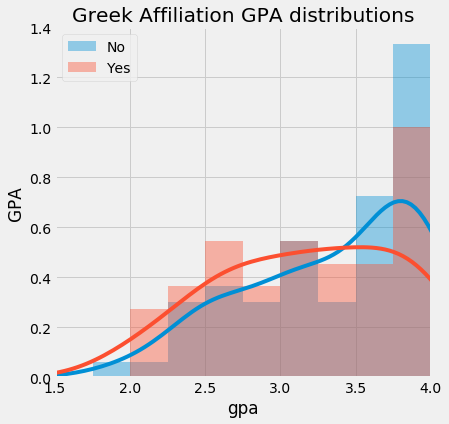

In [6]:
# Greek affiliation (yes vs. no) distributions 
bins = np.arange(1, 4.1, 0.25)
ax = sns.distplot(info.loc[info.greek.isnull()].gpa, bins=bins, label='No')
sns.distplot(info.loc[info.greek.notnull()].gpa, bins=bins, label='Yes')
plt.xlim(1.5, 4)
plt.legend()
plt.ylabel('Probability per unit GPA')
plt.ylabel('GPA')
plt.title('Greek Affiliation GPA distributions')
plt.show()

### Grade point correlations

* Some pairs of courses were infrequently taken by the same students
  + Calculating correlations for course pairs that occur at least 20 times
  + Course pairs with fewer than 20 observations were not calculated left blank in the heat map
<br><br>
* Many strong correlations were observed
  + Not surprising that past performance is indicative of future performance
  + Though individual students performance may change course to course
<br><br>  
* Some correlations are much stronger than others
  + Planning to determine confidence intervals to better judge how much of this is dues to noise 
  + Possibly some is due to courses with tighter grade distributions have less chance to be correlated
  + Possibly courses with more in common are more highly correlated
<br><br>
* No negative correlations were observed
  + Also not surprising, but might have been interesting

Notes on confidence interval for correlation
https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Using_the_Fisher_transformation


mean = artanh(r)

SE = 1 / sqrt(n - 3)

tanh(artanh - z_alpha_2 SE), tanh(artanh + z_alpha_2 SE)

i.e. r 0.3, n=50, tanh(0.30952 ± 1.96/√47),  (0.024, 0.534)



In [7]:
# Highest correlations
min_count = 20
min_periods = 20

corr_data = (data.groupby('course')
                 .filter(lambda group: len(group) >= min_count)
                 .pivot_table('point', 'id', 'course', aggfunc='mean')
                 .corr(min_periods=min_periods)
                 .stack()
                 .reset_index(level=1) 
                 .rename({'course':'course_2', 0:'correlation'}, axis=1)
                 .reset_index(level=0) 
                 .rename({'course':'course_1'}, axis=1)
)

print('Highest course pair grade point correlations:')

with pd.option_context('max_row', None,
                       'display.float_format', '{:,.2f}'.format):
    display(HTML(corr_data[(corr_data.course_1 < corr_data.course_2) & 
                      (corr_data.correlation > 0.7)]
                 .sort_values('correlation', ascending=False)
                 .to_html(index=False)))    


Highest course pair grade point correlations:


course_1,course_2,correlation
MTH-199,MTH-235,0.83
MTH-219,MTH-234,0.81
MTH-332,MTH-336,0.80
MTH-117,MTH-235,0.79
MTH-219,MTH-332,0.79
MTH-219,MTH-336,0.78
MTH-235,MTH-340,0.78
MTH-264,MTH-332,0.75
MTH-115H,MTH-340,0.73
MTH-199,MTH-264,0.72


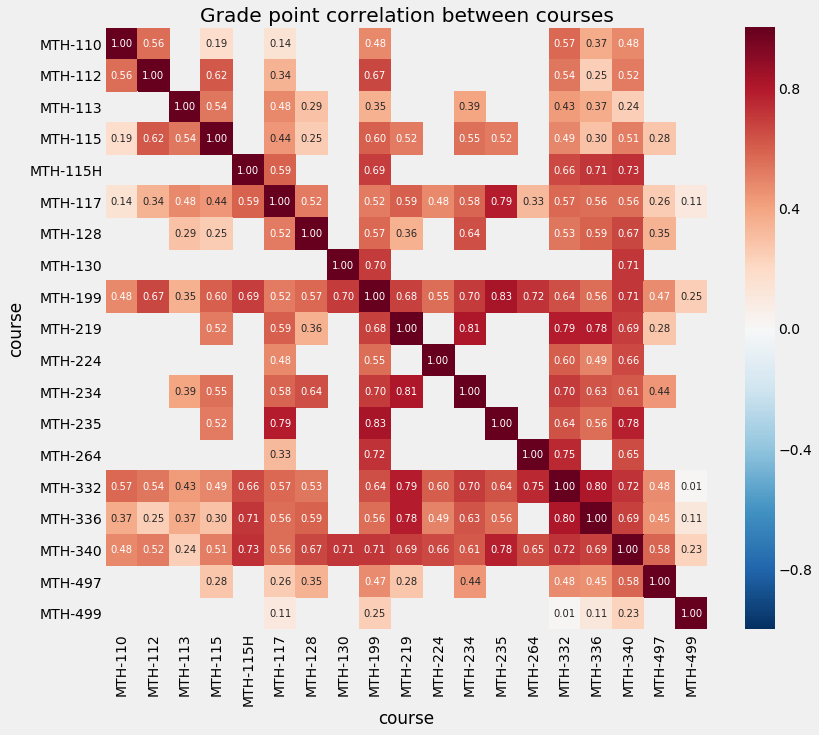

In [8]:
# Grade point correlation by course
min_count = 20    # exclude courses taken less than min_count times
min_periods = 20  # don't calculate correlation for course combinations 
                  # occuring less than min_periods

graph_data = (data.groupby('course')
                  .filter(lambda group: len(group) >= min_count)
                  .pivot_table('point', 'id', 'course', aggfunc='mean')
                  .corr(min_periods=min_periods)
             )

fig = plt.figure(figsize=(12, 12))
ax = (sns.heatmap(graph_data, 
                  vmin=-1, vmax=1, center=0,
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  annot=True, fmt='.2f', annot_kws={'fontsize':10},
                  square=True
                )
     )

plt.title('Grade point correlation between courses')
plt.show()

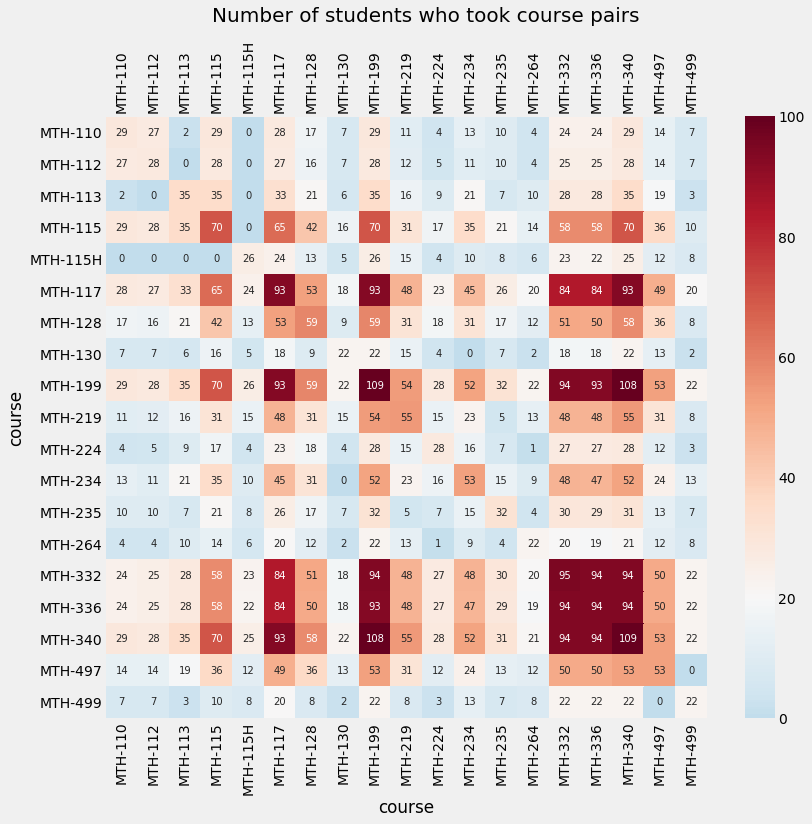

In [9]:
# Counts of times course pairs were taken by the same student
min_count = 20
corr_data = (data.groupby('course')
                 .filter(lambda group: len(group) >= min_count)
                 .pivot_table('point', 'id', 'course', aggfunc='max')
            )

pair_count = np.zeros((corr_data.shape[1], corr_data.shape[1]))
for index, row in pd.notnull(corr_data).iterrows():
    for i in range(len(row)):
        for j in range(i, len(row)):
            pair_count[i, j] += (int(row[i] and row[j]))
            if i != j:
                pair_count[j, i] += (int(row[i] and row[j]))

fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(pd.DataFrame(pair_count, index=corr_data.columns, 
                         columns=corr_data.columns),
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  vmin=0, vmax=100, center=20,
                  annot=True, fmt='.0f', annot_kws={'fontsize':10},
                  square=True
           )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.suptitle('Number of students who took course pairs',  
             y=0.95, x=0.45, fontsize=20)
plt.show()